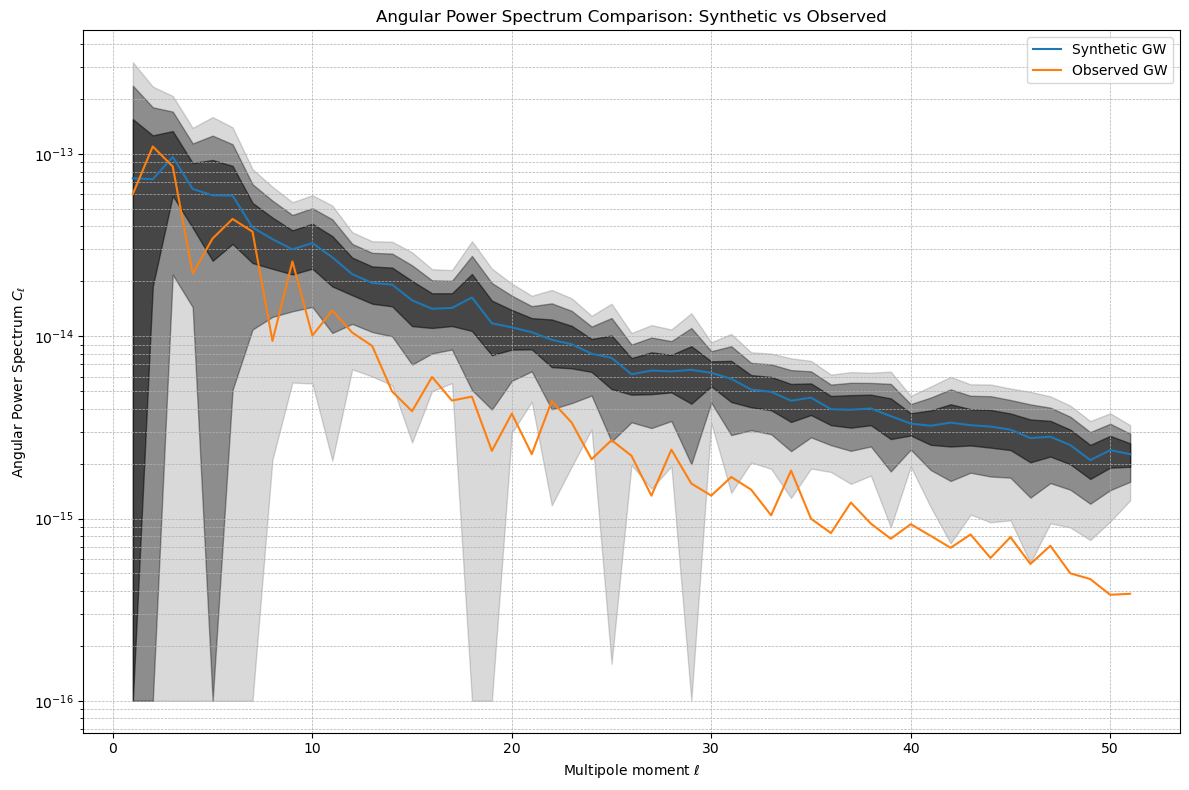

'\n\n# Plot the combined skymap\nplt.figure(figsize=(10, 6))\n\nhp.mollview(\n    synthetic_map,\n    title=f"Synthetic GW Skymaps ({len(synth_skymap_files)} events)",\n    min=0,\n    max=np.percentile(synthetic_map[synthetic_map > 0], 99),\n    cbar=True,\n    cmap=\'viridis\',\n    format=\'%.1e\',\n    unit="Probability Density $M_{GW}(\\chi,\\phi)$", \n    hold=True\n    )\n\nhp.graticule()\n'

In [ ]:

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from ligo.skymap.io.fits import read_sky_map
import glob
import re
from scipy.special import lpmv

lmax = 51  # Maximum multipole moment for power spectrum analysis

# Load observed skymap from .npy file
observed_map = np.load('/Users/leo/Desktop/gw-hands-on-school-2025/paper_folder/GWTC-4_mixed_combined_skymap.npy')

#Change this path to where the synthetic skymaps are stored
base_path = "/Users/leo/Library/CloudStorage/Dropbox/gw.phy.cuhk.edu.hk/static/new_simulated_skymaps"
synth_skymap_files = []

def compute_correlation_function(cl, theta_degrees, lmax):
    """
    Compute angular correlation function C(θ) from Cℓ.
    
    Formula: C(θ) = 1/(4π) * Σ_{ℓ=0}^{ℓmax} (2ℓ+1) Cℓ Pℓ(cos θ)
    """
    ell = np.arange(lmax + 1)
    theta_rad = np.radians(theta_degrees)
    cos_theta = np.cos(theta_rad)
    
    C_theta = np.zeros_like(theta_degrees, dtype=np.float64)
    
    for l in ell:
        # Legendre polynomial Pℓ(cos θ)
        P_l = lpmv(0, l, cos_theta)
        # Add contribution
        C_theta += (2*l + 1) * cl[l] * P_l
    
    # Normalize by 4π
    C_theta = C_theta / (4 * np.pi)
    
    return C_theta


def normalize_cosmology_style(cl):
    """Normalize by ℓ(ℓ+1)/2π (standard in CMB analysis)."""
    
    with np.errstate(divide='ignore', invalid='ignore'):
        cl_norm = cl * ell * (ell + 1) / (2 * np.pi)
        cl_norm[0] = cl[0]  # ℓ=0 is 0 with this normalization
    return cl_norm

ell = np.arange(lmax+1) # array of Multipole moments

cl_tot_array = []  # To store individual skymaps if needed
C_theta_array = []

theta_degrees = np.linspace(0.0, 180.0, 10000)  # 0 to 180 degrees
theta_degrees = np.sort(theta_degrees)  # Ensure sorted

# Define the main set ranges
set_ranges = [
    ("sets_0_99", range(0, 85)), #CHANGE HERE FOR SET RANGES, we only use 85 files from each set to match the observed events.
    ("sets_100_199", range(100, 185)),
    ("sets_200_299", range(200, 285)),
    ("sets_300_399", range(300, 385)),
    ("sets_400_499", range(400, 485)),
    ("sets_500_599", range(500, 585)),
    ("sets_600_699", range(600, 685)),
    ("sets_700_799", range(700, 785)),
    ("sets_800_899", range(800, 885)),
    ("sets_900_999", range(900, 985))

]
#-------------------------------------------------------------------------------------
for set_range, set_numbers in set_ranges: 

        
        pattern = f"{base_path}/{set_range}/*.fits.gz"
        all_files = glob.glob(pattern)

        synth_skymap_files = []
        for file in all_files:
        # Extract number from filename
            match = re.search(r'H1L1_(\d+)\.fits\.gz$', file)
            if match:
                num = int(match.group(1))
                if num in set_numbers:
                    synth_skymap_files.append(file)

    
        NSIDE = 256
        NPIX = hp.nside2npix(NSIDE)
            
            # Define the combined (added) skymap
        synthetic_map = np.zeros(NPIX)
            
            # Process the skymaps
        for i, fits_file in enumerate(synth_skymap_files):
            try:
                # Read skymap
                skymap, header = read_sky_map(fits_file, nest=False, distances=False, moc=False)
                    
                # Resample to common resolution(important with power=-2)
                skymap_resized = hp.ud_grade(skymap, NSIDE, pess=False, order_in='RING', order_out='RING', power=-2, dtype=None)
                
                # Add to combined map
                synthetic_map += skymap_resized / np.sum(skymap_resized)  # Normalize each map before adding
                        
            except Exception as e:
                print(f"Error reading {fits_file}: {e}")
                continue
            

        synthetic_map = synthetic_map / len(synth_skymap_files)  # Normalize combined map
        cl_synth = hp.anafast(synthetic_map, lmax=lmax) #an array of C_ell values 
        cl_tot_array.append(cl_synth) 

        C_theta = compute_correlation_function(cl_synth, theta_degrees, lmax)
        C_theta_array.append(C_theta)

cl_tot_array = np.array(cl_tot_array) #Make into numpy array
C_theta_array = np.array(C_theta_array) #Make into numpy array
    

cl_mean = np.mean(cl_tot_array, axis=0) #Mean 
cl_std = np.std(cl_tot_array, axis=0, ddof=1) #std

C_theta_mean = np.mean(C_theta_array, axis=0)
C_theta_std = np.std(C_theta_array, axis=0, ddof=1)

# computing cl_mean and cl_std
cl_1sigma_upper = cl_mean + cl_std
cl_1sigma_lower = cl_mean - cl_std

cl_2sigma_upper = cl_mean + 2 * cl_std
cl_2sigma_lower = cl_mean - 2 * cl_std

cl_3sigma_upper = cl_mean + 3 * cl_std
cl_3sigma_lower = cl_mean - 3 * cl_std


# Compute sigma bands for correlation function
C_theta_1sigma_upper = C_theta_mean + C_theta_std
C_theta_1sigma_lower = C_theta_mean - C_theta_std

C_theta_2sigma_upper = C_theta_mean + 2 * C_theta_std
C_theta_2sigma_lower = C_theta_mean - 2 * C_theta_std

C_theta_3sigma_upper = C_theta_mean + 3 * C_theta_std
C_theta_3sigma_lower = C_theta_mean - 3 * C_theta_std

# Plot with fill_between for nice shaded regions
plt.figure(figsize=(12, 8))

# Plot 3σ region first (so it's in the background)
plt.fill_between(ell[1:], 
                    np.maximum(1e-16, cl_3sigma_lower[1:]),  # Avoid negative values for log scale
                    cl_3sigma_upper[1:], 
                    alpha=0.15, color='black')

    # Plot 2σ region on top
plt.fill_between(ell[1:], 
                    np.maximum(1e-16, cl_2sigma_lower[1:]), 
                    cl_2sigma_upper[1:], 
                    alpha=0.35, color='black')

    # Plot 1σ region on top
plt.fill_between(ell[1:], 
                    np.maximum(1e-16, cl_1sigma_lower[1:]), 
                    cl_1sigma_upper[1:], 
                    alpha=0.5, color='black')

plt.plot(ell[1:], cl_mean[1:],  label=f'Synthetic GW')
plt.plot(ell[1:], hp.anafast(observed_map, lmax=lmax)[1:], label='Observed GW')
plt.yscale('log')
plt.xlabel(r'Multipole moment $\ell$')
plt.ylabel(r'Angular Power Spectrum $C_\ell$')
plt.title(f'Angular Power Spectrum Comparison: Synthetic vs Observed')
plt.legend()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.tight_layout()
plt.show()



'''
    
# Plot the combined skymap
plt.figure(figsize=(10, 6))
    
hp.mollview(
    synthetic_map,
    title=f"Synthetic GW Skymaps ({len(synth_skymap_files)} events)",
    min=0,
    max=np.percentile(synthetic_map[synthetic_map > 0], 99),
    cbar=True,
    cmap='viridis',
    format='%.1e',
    unit="Probability Density $M_{GW}(\chi,\phi)$", 
    hold=True
    )
    
hp.graticule()
'''

In [29]:
print(len(ell))
print(cl_tot_array.shape)

print(hp.anafast(observed_map, lmax=lmax).shape)

52
(100, 52)
(52,)


Replot the graph from above

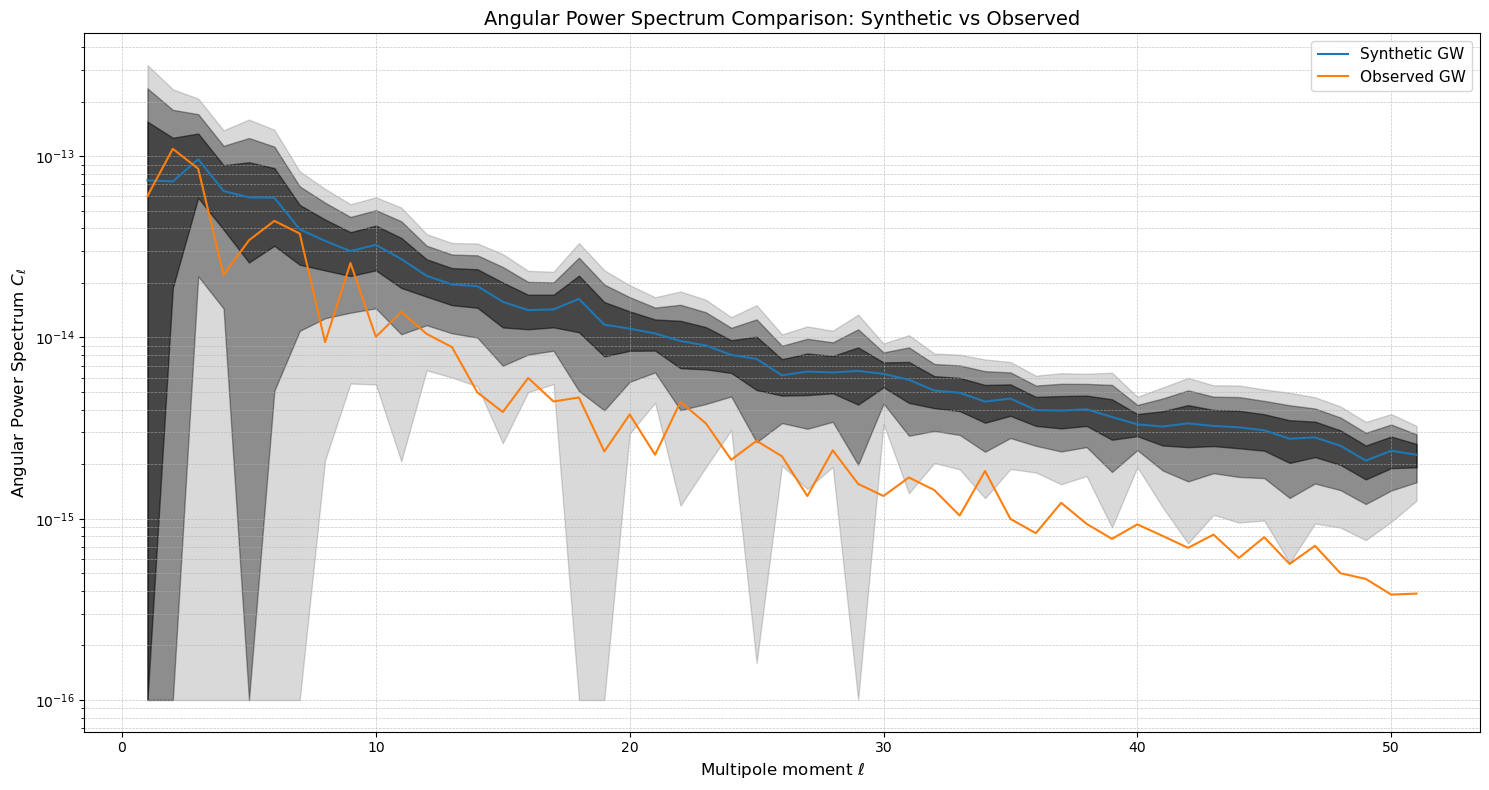

In [43]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# Your existing code with minimal changes
observed_map = np.load('/Users/leo/Desktop/gw-hands-on-school-2025/paper_folder/GWTC-4_mixed_combined_skymap.npy')
plt.figure(figsize=(15, 8))

# Plot 3σ region first (so it's in the background)
plt.fill_between(ell[1:], 
                 np.maximum(1e-16, cl_3sigma_lower[1:]),  # Avoid negative values for log scale
                 cl_3sigma_upper[1:], 
                 alpha=0.15, color='black')

# Plot 2σ region on top
plt.fill_between(ell[1:], 
                 np.maximum(1e-16, cl_2sigma_lower[1:]), 
                 cl_2sigma_upper[1:], 
                 alpha=0.35, color='black')

# Plot 1σ region on top
plt.fill_between(ell[1:], 
                 np.maximum(1e-16, cl_1sigma_lower[1:]), 
                 cl_1sigma_upper[1:], 
                 alpha=0.5, color='black')

plt.plot(ell[1:], cl_mean[1:], label=f'Synthetic GW')
plt.plot(ell[1:], hp.anafast(observed_map, lmax=lmax)[1:], 
         label='Observed GW')  # Added markersize for better PDF
plt.yscale('log')
plt.xlabel(r'Multipole moment $\ell$', fontsize=12)
plt.ylabel(r'Angular Power Spectrum $C_\ell$', fontsize=12)
plt.title(f'Angular Power Spectrum Comparison: Synthetic vs Observed', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, which='both', ls='--', lw=0.5, alpha=0.7)

# Tight layout for better spacing
plt.tight_layout()

# SAVE AS VECTOR PDF (this is the key line!)
plt.savefig('angular_power_spectrum.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Optional: Show plot on screen too
plt.show()

# Optional: Close the figure to free memory
plt.close()

Plotting correlation function $C(\theta)$ against $\theta$  

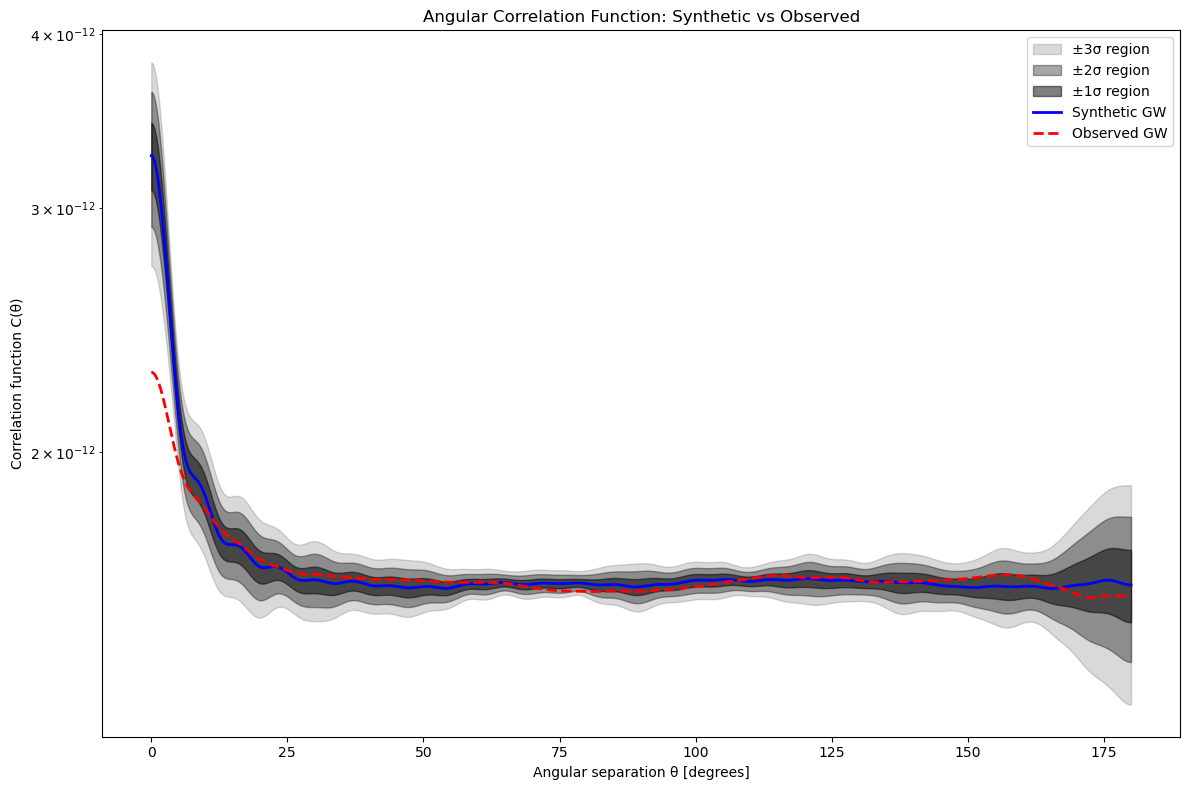

In [42]:
plt.figure(figsize=(12, 8))
cl_obs = hp.anafast(observed_map, lmax=lmax)
C_theta_obs = compute_correlation_function(cl_obs, theta_degrees, lmax)

    # Plot 3σ region first
plt.fill_between(theta_degrees, 
                    np.maximum(C_theta_3sigma_lower, 1e-14),
                    C_theta_3sigma_upper, 
                    alpha=0.15, color='black', label='±3σ region')

    # Plot 2σ region on top
plt.fill_between(theta_degrees, 
                    np.maximum(C_theta_2sigma_lower, 1e-14),
                    C_theta_2sigma_upper, 
                    alpha=0.35, color='black', label='±2σ region')

    # Plot 1σ region on top
plt.fill_between(theta_degrees, 
                    np.maximum(C_theta_1sigma_lower, 1e-14), 
                    C_theta_1sigma_upper, 
                    alpha=0.5, color='black', label='±1σ region')

    # Plot mean correlation function
plt.plot(theta_degrees, C_theta_mean, 'b-', linewidth=2, 
             label=f'Synthetic GW')

plt.plot(theta_degrees, C_theta_obs, 'r--', linewidth=2, 
             label='Observed GW')

plt.xlabel('Angular separation θ [degrees]')
plt.ylabel('Correlation function C(θ)')
plt.title(f'Angular Correlation Function: Synthetic vs Observed')
plt.yscale('log')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
np.save('GW_synthetic_skymap_set4.npy', synthetic_map)



Synthetic Skymap

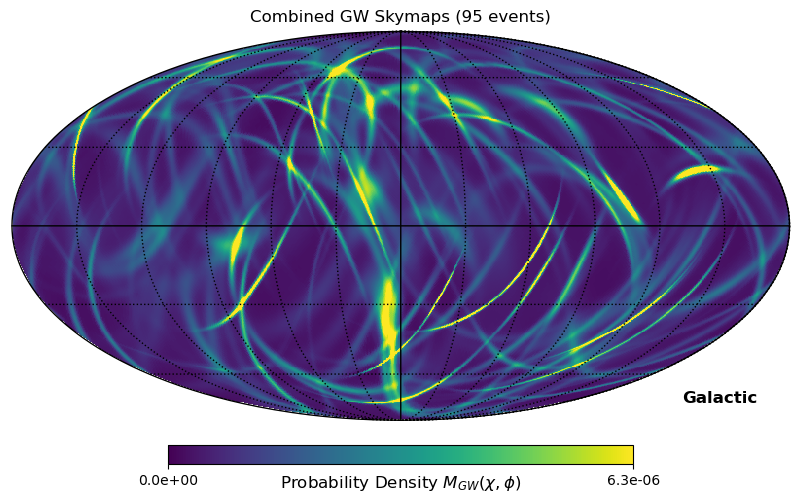

In [41]:
plt.figure(figsize=(12, 6))
    
hp.mollview(
    synthetic_map,
    title=f"Combined GW Skymaps ({len(synth_skymap_files)} events)",
    min=0,
    max=np.percentile(synthetic_map[synthetic_map > 0], 99),
    cbar=True,
    cmap='viridis',
    format='%.1e',
    coord='G',
    unit="Probability Density $M_{GW}(\chi,\phi)$", 
    hold=True
    )

hp.graticule()